# Proyek Klasifikasi Gambar: Malaria
- **Nama:** Walker Valentinus Simanjuntak
- **Email:** walkervalentinussimanjuntak@gmail.com
- **ID Dicoding:** walkervs

## Import Library

In [1]:
import os
import shutil
import random
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2026-02-06 15:08:55.983561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770390536.177201      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770390536.241138      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770390536.719796      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770390536.719837      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770390536.719839      24 computation_placer.cc:177] computation placer alr

## Data Load

In [2]:
import requests
import zipfile
from pathlib import Path

# Set our data path
data_path = Path("/kaggle/working/")
image_path = data_path / "malaria"

# Download if image folder is empty
if image_path.is_dir():
    print(f"{image_path} already exists.")
else:
    print(f"Can't find {image_path}, creating dir...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download malaria dataset
    with open(data_path / "malaria.zip", "wb") as f:
        request = requests.get("https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip")
        print("Downloading data...")
        f.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / "malaria.zip", "r") as zip_ref:
        print("Unzipping data...") 

        zip_ref.extractall(image_path)

Can't find /kaggle/working/malaria, creating dir...
Unzipping data...


In [3]:
# This path filled with 2 folders, Parasitized and Uninfected
# Our idea is to split this images to train and test 
images = image_path / "cell_images"
images

PosixPath('/kaggle/working/malaria/cell_images')

## Data Prep

In [4]:
# Uncomment if split-folders not installed yet
!pip -q install split-folders

In [5]:
# This library will automatically create a new folder structure
import splitfolders

input_folder = images
output_folder = image_path / "split_dataset"

splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.7, .15, .15), 
                   group_prefix=None, move=False)

Copying files: 27560 files [00:04, 6186.16 files/s]


In [6]:
def scan_dir(path):
  """
  Scan the directory and return its contents.
  Args:
    path (str or pathlib.Path): destination directory
  
  Returns:
    A display of:
      subdiretories in destination directory
      how many images (files) in each sub-directory
      subdirectory names
  """
  for path, dirnames, filenames in os.walk(path):
    print(f"Found {len(dirnames)} directories & {len(filenames)} images in '{path}'.")

scan_dir(output_folder)

Found 3 directories & 0 images in '/kaggle/working/malaria/split_dataset'.
Found 2 directories & 0 images in '/kaggle/working/malaria/split_dataset/test'.
Found 0 directories & 2067 images in '/kaggle/working/malaria/split_dataset/test/Uninfected'.
Found 0 directories & 2067 images in '/kaggle/working/malaria/split_dataset/test/Parasitized'.
Found 2 directories & 0 images in '/kaggle/working/malaria/split_dataset/val'.
Found 0 directories & 2067 images in '/kaggle/working/malaria/split_dataset/val/Uninfected'.
Found 0 directories & 2067 images in '/kaggle/working/malaria/split_dataset/val/Parasitized'.
Found 2 directories & 0 images in '/kaggle/working/malaria/split_dataset/train'.
Found 0 directories & 9646 images in '/kaggle/working/malaria/split_dataset/train/Uninfected'.
Found 0 directories & 9646 images in '/kaggle/working/malaria/split_dataset/train/Parasitized'.


In [7]:
# Setup our train, val, and test data path
train_path = output_folder/"train"
val_path = output_folder/"val"
test_path = output_folder/"test"

print(train_path)
print(val_path)
print(test_path)

/kaggle/working/malaria/split_dataset/train
/kaggle/working/malaria/split_dataset/val
/kaggle/working/malaria/split_dataset/test


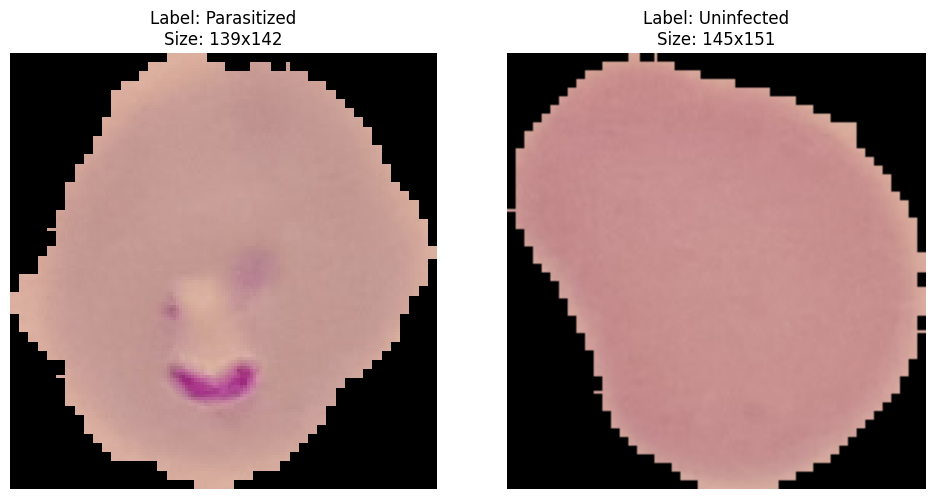

In [8]:
target_classes = sorted([entry.name for entry in train_path.iterdir() if entry.is_dir()])

# 1 cols and 2 rows to show our binary label
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

random.seed(84)

for i, malaria_class in enumerate(target_classes):
    # png format for Malaria dataset
    class_images = list((train_path / malaria_class).glob("*.png"))

    if class_images:
        path_img_rand = random.choice(class_images)
        img = Image.open(path_img_rand)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {malaria_class}\nSize: {img.width}x{img.height}", fontsize=12)
        axes[i].axis("off")

plt.tight_layout()
plt.show()

In [9]:
import tensorflow as tf

def load_malaria_datasets(base_path, target_size=(224, 224), batch_size=32):
    # path from split folders
    train_dir = base_path / "train"
    val_dir = base_path / "val"
    test_dir = base_path / "test"

    # Load Train
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=target_size,
        batch_size=batch_size,
        label_mode='binary', 
        shuffle=True
    )

    # Load Validation
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        image_size=target_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=False
    )

    # Load Test
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=target_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=False
    )
    
    return train_ds, val_ds, test_ds

In [10]:
# Base path
base_path = image_path / "split_dataset"

# Call the function
train_ds, val_ds, test_ds = load_malaria_datasets(base_path)

class_names = train_ds.class_names
print(f"{class_names}")

Found 19290 files belonging to 2 classes.


I0000 00:00:1770390566.615955      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770390566.622318      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 4134 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.
['Parasitized', 'Uninfected']


In [11]:
from tensorflow.keras import layers, models

# Initialize Augmentation and Rescale as a Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomGaussianBlur(factor=1.0, sigma=0.1),
    layers.RandomShear(x_factor=0.2, fill_mode="reflect"),
    layers.Rescaling(1./255)
])

In [12]:
# Apply augmentation function
def apply_augmentation(images, labels):
    images = data_augmentation(images, training=True)
    return images, labels

# Augmentation only for train dataset 
train_ds_augmented = train_ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# For Val dan Test, we only need to rescale it
rescale_layer = tf.keras.layers.Rescaling(1./255)

val_ds_rescaled = val_ds.map(lambda x, y: (rescale_layer(x), y))
test_ds_rescaled = test_ds.map(lambda x, y: (rescale_layer(x), y))

## Modelling

In [13]:
# Setup Callbacks 
callbacks = [
    # Early Stopping: Stop if val_loss doesn't improve for 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,               # Wait 5 epochs
        restore_best_weights=True # Automatically switch back to the best weights found
    ),
    # Reduce LR on Plateau: Lower learning rate if progress stalls
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,             
        patience=3,             
        min_lr=1e-6,            
        verbose=1               
    )
]

### MobileNetV2

In [14]:
# Load the Pretrained Model
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base initially
mobilenet.trainable = False

# Build the Model
model_0 = models.Sequential([
    
    layers.Input(shape=(224, 224, 3)),
    
    # Pretrained block
    mobilenet, 
    
    # Custom Layers (Conv2D and Pooling Layer), Input (7x7) -> Output (3x3)
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Custom Layers 2 (Conv2D and Pooling Layer), Input (3x3) -> Output (1x1)
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Custom Layers 3 Input (1x1) - Only apply Conv2D and BatchNormalization, no more spatial pooling
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),

    # Custom Layers 4 Input (1x1) - Only apply Conv2D and BatchNormalization, no more spatial pooling
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
    
    # Dense Layers / Classifier
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(32, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(1, activation='sigmoid')
])

model_0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_0.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,878,753 (10.98 MB)

 Trainable params: 619,873 (2.36 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

In [15]:
history_0 = model_0.fit(train_ds_augmented, validation_data=val_ds_rescaled, epochs=50, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1770390579.677968      83 service.cc:152] XLA service 0x7ca51400eff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770390579.678020      83 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770390579.678026      83 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770390581.482797      83 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-06 15:09:49.859009: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 15:09:49.997683: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1770390594.533009      83 device_co

602/603 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7572 - loss: 0.4959

2026-02-06 15:12:24.536086: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 15:12:24.673225: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7573 - loss: 0.4957

2026-02-06 15:12:44.727846: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 15:12:44.875798: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 15:12:45.012537: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


603/603 ━━━━━━━━━━━━━━━━━━━━ 197s 286ms/step - accuracy: 0.7575 - loss: 0.4955 - val_accuracy: 0.9185 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.9183 - loss: 0.2444 - val_accuracy: 0.9398 - val_loss: 0.1861 - learning_rate: 1.0000e-04
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 146s 241ms/step - accuracy: 0.9326 - loss: 0.2087 - val_accuracy: 0.9405 - val_loss: 0.1659 - learning_rate: 1.0000e-04
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/step - accuracy: 0.9338 - loss: 0.1921 - val_accuracy: 0.9482 - val_loss: 0.1568 - learning_rate: 1.0000e-04
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 146s 241ms/step - accuracy: 0.9372 - loss: 0.1830 - val_accuracy: 0.9523 - val_loss: 0.1442 - learning_rate: 1.0000e-04
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.9372 - loss: 0.1826 - val_accuracy: 0.9526 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/

## Visualization

In [16]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

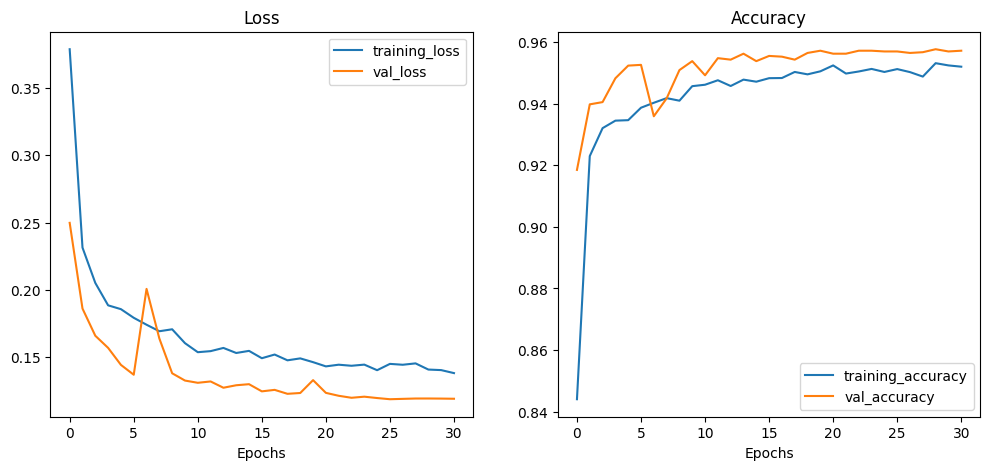

In [17]:
plot_loss_curves(history_0)

## Evaluation

In [18]:
test_loss, test_acc = model_0.evaluate(test_ds_rescaled)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9429 - loss: 0.1485
Test Accuracy: 95.45%
Test Loss: 0.1359


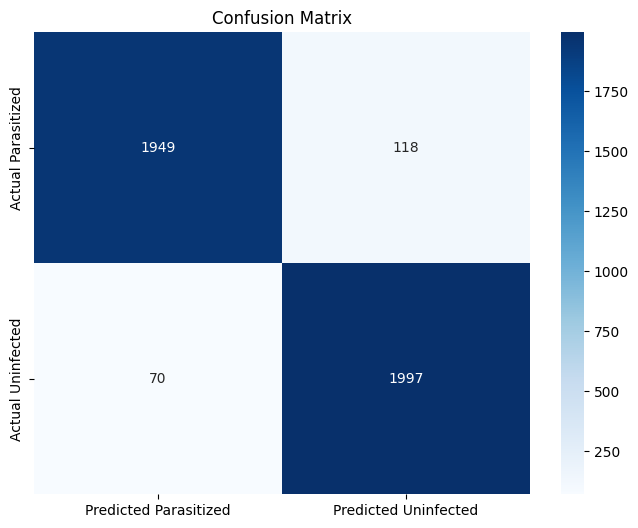


Classification Report:

              precision    recall  f1-score   support

 Parasitized     0.9653    0.9429    0.9540      2067
  Uninfected     0.9442    0.9661    0.9550      2067

    accuracy                         0.9545      4134
   macro avg     0.9548    0.9545    0.9545      4134
weighted avg     0.9548    0.9545    0.9545      4134



In [19]:
preds_0 = model_0.predict(test_ds_rescaled,verbose=0)
preds_0 = preds_0.copy()
preds_0[preds_0 <= 0.5] = 0
preds_0[preds_0 > 0.5] = 1

# Get label in test_ds
y_true = np.concatenate([y for x, y in test_ds_rescaled], axis=0)
# Flatten the label to 1D array
preds_0_flat = preds_0.flatten()

# 0 = Parasitized, 1 = Uninfected
target_names = ['Parasitized', 'Uninfected']

# Create Confusion Matrix
cm_data = confusion_matrix(y_true, preds_0_flat)
cm = pd.DataFrame(cm_data, 
                  index=[f"Actual {name}" for name in target_names],
                  columns=[f"Predicted {name}" for name in target_names])

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, preds_0_flat, target_names=target_names, digits=4))

## Model Conversion

In [20]:
# Format .keras Model
save_path = data_path / 'mymodel' / 'model_0.keras'
save_path.parent.mkdir(parents=True, exist_ok=True)
model_0.save(save_path)

In [21]:
# Format Saved Model
export_path = data_path / 'saved_model'
model_0.export(export_path)

INFO:tensorflow:Assets written to: /kaggle/working/saved_model/assets


INFO:tensorflow:Assets written to: /kaggle/working/saved_model/assets


Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137052705730832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705731984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705731408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705734288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705733904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705733520: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [22]:
# Convert SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_0)
tflite_model = converter.convert()

with open('tflite_model_clean.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpss5sfvgw/assets


INFO:tensorflow:Assets written to: /tmp/tmpss5sfvgw/assets


Saved artifact at '/tmp/tmpss5sfvgw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137052705730832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705731984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705731408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705732368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705734288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705733904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137052705733520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1370527057

W0000 00:00:1770395206.266443      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1770395206.266477      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1770395206.431331      24 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [23]:
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ray 2.53.0 requires packaging>=24.2, but you have packaging 23.2 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is inco

In [24]:
# Convert SavedModel to TFJS
import tensorflowjs as tfjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/saved_model \
    /kaggle/working/modeltfjs

2026-02-06 16:26:58.998648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770395219.021482    1082 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770395219.028682    1082 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770395219.047565    1082 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770395219.047593    1082 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770395219.047598    1082 computation_placer.cc:177] computation placer alr

## Inference